In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'
from data import *
from load_atoms import load_dataset
from ase.io import read, extxyz
import numpy as np
import matplotlib.pyplot as plt
import jax
import matplotlib.pyplot as plt
from model import Nequix
import pickle

In [3]:
species = [1, 6, 7, 8, 16]
atomic_indices = atomic_numbers_to_indices(species)

In [5]:
ds = load_dataset('QM7', 'data')
with open('data/densities.pkl', 'rb') as f:
    densities = pickle.load(f)

for i, atom in enumerate(ds):
    atom.set_cell(np.eye(3))
    atom.info['P'] = densities['densities'][i]

#extxyz.write_extxyz('data/QM7.extxyz', ds)

Output()

In [6]:
graph_ds = Dataset('data/QM7.extxyz', atomic_indices)
dl = DataLoader(graph_ds, 23, 490, 15, 210, 64)

In [7]:
a, gt, mask = next(iter(dl))
a

GraphsTuple(nodes={'positions': array([[ 0.99826, -0.00246, -0.00436],
       [ 2.09021, -0.00243,  0.00414],
       [ 0.63379,  1.02686,  0.00414],
       ...,
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ],
       [ 0.     ,  0.     ,  0.     ]], dtype=float32), 'species': array([1, 0, 0, ..., 0, 0, 0], dtype=int32)}, edges={'shifts': array([[ 0., -1., -1.],
       [ 0., -1., -1.],
       [ 0., -1., -1.],
       ...,
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]], dtype=float32)}, receivers=array([  0,   0,   0, ..., 640, 640, 640], dtype=int32), senders=array([  1,   2,   3, ..., 640, 640, 640], dtype=int32), globals=array([[[ 2.06576157e+00, -2.03388795e-01, -1.29640584e-05, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-2.03388795e-01,  7.97058642e-01, -7.90893228e-06, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [-1.29640584e-05, -7.90893228e-06,  6.51722670e-01, ...,


In [69]:
model = Nequix(jax.random.key(69), basis='def2-tvp')

/Users/luka/nequix/.venv/lib/python3.10/site-packages/pyscf/gto/basis/__init__.py:661: UserWarning: Basis may be available in basis-set-exchange. It is recommended to install basis-set-exchange: pip install basis-set-exchange
  warnings.warn(


BasisNotFoundError: Unknown basis format or basis name for def2-tvp

In [68]:
a, gt, mask = next(iter(dl))
P = model(a)

1x0e+1x1o+1x2e+1x3o
[[ 1.0000000e+00  1.7319982e+00  4.7584545e-05 ... -1.2611525e-02
  -1.4073990e-04 -4.8840281e-02]
 [ 1.0000000e+00 -5.7810885e-01  1.6326692e+00 ...  4.3417774e-02
  -5.3772956e-01 -5.4404601e-03]
 [ 1.0000000e+00 -5.8880150e-01 -8.3314413e-01 ...  2.0540701e-01
  -1.3246509e+00  5.1786602e-01]
 ...
 [ 1.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 1.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]


In [15]:
P = gt[0]

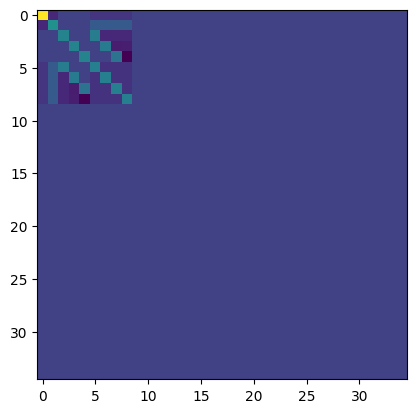

In [16]:
plt.imshow(P)

In [17]:
import pyscf

In [26]:
xyz = a.nodes['positions'][:5]
species = a.nodes['species'][:5]

In [33]:
species_elemental = np.array([6,1,1,1,1])

In [60]:
mol = pyscf.gto.Mole(
    atom=list(zip(species_elemental, xyz)), 
    basis='sto-3g',
    aux_basis='def2-svp'
    )
mol.build()

In [61]:
R_mat = mol.intor('int3c1e')

In [ ]:
mol.intor

In [62]:
R_mat.shape

(9, 9, 9)

In [53]:
mf = pyscf.scf.RHF(mol)
mf.kernel()
c = mf.mo_coeff
P = c @ np.diag(mf.mo_occ) @ c.T

converged SCF energy = -39.7265814242284


In [63]:
P_dr = np.einsum('ijk, jk -> i', R_mat, P)

In [65]:
P_dr.shape

(9,)